<a href="https://colab.research.google.com/github/alunfes/1m-btc-data/blob/master/LGBM_Vola_Rrgression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep 10 13:17:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#%cp -rp '/content/drive/My Drive/ta-lib/' ~/
%cd ~
!rm -rf ta-lib*
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd '/content/drive/My Drive/ta-lib'
#%cd ta-lib
import os
#os.chdir('/content/drive/My Drive/ta-lib') # Can't use !cd in co-lab
os.chdir('ta-lib') # Can't use !cd in co-lab
#%cd ~/ta-lib
!./configure --prefix=/usr
#! '/content/drive/My Drive/ta-lib/configure' --prefix=/usr
!make
!make install
!pip install Ta-Lib
%cd /content

/root
--2022-09-10 13:18:08--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving sourceforge.net (sourceforge.net)... 172.64.153.13, 104.18.34.243
Connecting to sourceforge.net (sourceforge.net)|172.64.153.13|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/ [following]
--2022-09-10 13:18:08--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download [following]
--2022-09-10 13:18:08--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 302 Found
Locat

In [5]:
!pip install optuna
!pip install joblib
!pip install six
!pip install bayesian-optimization
#!pip install stable-baselines3 --upgrade
#!pip install tensorboardcolab
#!pip --no-cache-dir install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

#!pip install lightgbm --install-option=--GPU
#!sudo pip --no-cache-dir install -I lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

import lightgbm as lgb
from sklearn import datasets
import dateutil
import copy
import sqlite3
from math import ceil, floor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import pickle
import csv
import math
import talib as ta
import matplotlib.pyplot as plt
from scipy.spatial.distance import correlation
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
import sklearn.metrics
from sklearn.model_selection import train_test_split
from functools import partial
import optuna
import joblib
from joblib import Parallel, delayed
import time
import random
import collections

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 7.3 MB/s 
     |████████████████████████████████| 209 kB 58.6 MB/s 
     |████████████████████████████████| 81 kB 8.9 MB/s 
     |████████████████████████████████| 78 kB 7.1 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
     |████████████████████████████████| 147 kB 51.7 MB/s 
     |████████████████████████████████| 112 kB 62.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=b7bd45454d5fa86833bc658b5d8fae6c1698b70175adee1a8d649faa8d19872c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in i

In [6]:
class MarketData:
    @classmethod
    def initialize(cls, from_ratio:float, end_ratio:float, terms_type:int, future_vola_term:int):
        cls.terms = []
        if terms_type==0:
            cls.terms = [15, 25, 50, 100, 150, 200] #min period should be 15 as some index use term / 3.0
        elif terms_type==1:
            cls.terms = [15, 25, 50, 100, 150, 300, 400, 800, 1000, 1440]
        else:
            cls.terms = [15, 25, 50, 100, 150, 300, 400, 600, 800, 1000, 1200, 1440, 1600, 1800]
        cls.df = pd.DataFrame()
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.vol = []
        cls.low_vola = []
        cls.high_vola = []
        cls.ma = {}
        cls.ma_kairi = {}
        cls.rsi = {}
        cls.atr = {}
        cls.aroon_os = {}
        cls.cci = {}
        cls.dx = {}
        cls.macd = {}
        cls.macd_signal = {}
        cls.macd_hist = {}
        cls.rate_of_change = {}
        cls.williams_r = {}
        cls.correlation = {}
        cls.momentum_size = {}
        cls.stochastic = {}
        cls.bop = []
        cls.cmo = {}
        cls.adxr = {}
        cls.apo = {}
        cls.macdfix = {}
        cls.macdfix_signal = {}
        cls.macdfix_hist = {}
        cls.minus_di = {}
        cls.plus_di = {}
        cls.plus_minus_di = {}
        cls.ppo = {}
        cls.ultosc = {}
        cls.atr = {}
        cls.CDL3INSIDE = []
        cls.CDL2CROWS = []
        cls.CDLIDENTICAL3CROWS = []
        cls.CDL3LINESTRIKE = []
        cls.CDLADVANCEBLOCK = []
        cls.CDL3OUTSIDE = []
        cls.CDL3STARSINSOUTH = []
        cls.CDLBELTHOLD = []
        cls.CDLBREAKAWAY = []
        cls.CDLCOUNTERATTACK = []
        cls.CDLDOJI = []
        cls.CDLDRAGONFLYDOJI = []
        cls.CDLGAPSIDESIDEWHITE = []
        cls.CDLHANGINGMAN = []
        cls.CDLHARAMI = []
        cls.CDLHARAMICROSS = []
        cls.CDLTASUKIGAP = []

        cls.__read_data()
        cls.__cut_data(from_ratio, end_ratio)
        cls.__calc_index()
        cls.low_vola, cls.high_vola = cls.__generate_future_vola(future_vola_term)
        print('initialized MarketData')
    
    @classmethod
    def __read_data(cls):
        cls.df = pd.read_csv('/content/drive/My Drive/BTC-PERP-1mcp.csv')
        cls.ts = list(cls.df['ts'])
        cls.open = list(cls.df['open'])
        cls.high = list(cls.df['high'])
        cls.low = list(cls.df['low'])
        cls.close = list(cls.df['close'])
        cls.vol = list(cls.df['volume'])


    
    @classmethod
    def __cut_data(cls, from_ratio:float, end_ratio:float):
        from_ind = int(len(cls.df) * from_ratio)
        end_ind = int(len(cls.df) * end_ratio)
        cls.df = cls.df.iloc[from_ind:end_ind]
        cls.ts = cls.ts[from_ind:end_ind]
        cls.open = cls.open[from_ind:end_ind]
        cls.high = cls.high[from_ind:end_ind]
        cls.low = cls.low[from_ind:end_ind]
        cls.close = cls.close[from_ind:end_ind]
        cls.vol = cls.vol[from_ind:end_ind]

    @classmethod
    def __generate_future_vola(cls, term:int):
        low_vola = []
        high_vola = []
        for i in range(len(cls.close) - term):
            i += term
            high_vola.append( (max(cls.high[i - term:i]) - cls.close[i-term]) / cls.close[i-term])
            low_vola.append( (min(cls.low[i - term:i]) - cls.close[i-term]) / cls.close[i-term])
        for i in range(term):
            high_vola.append(np.nan)
            low_vola.append(np.nan)
        return low_vola, high_vola

    @classmethod
    def __calc_index(cls):
        for term in cls.terms:
            cls.ma[term] = cls.__calc_ma(term)
            cls.ma_kairi[term] = cls.__calc_ma_kairi(term)
            cls.rsi[term] = cls.__calc_rsi(term)
            cls.atr[term] = cls.__calc_atr(term)
            cls.aroon_os[term] = cls.__calc_aroon_os(term)
            cls.cci[term] = cls.__calc_cci(term)
            cls.dx[term] = cls.__calc_dx(term)
            cls.macd[term] = cls.__calc_macd(term)
            cls.macd_signal[term] = cls.__calc_macd_signal(term)
            cls.macd_hist[term] = cls.__calc_macd_hist(term)
            cls.rate_of_change[term] = cls.__calc_rate_of_change(term)
            cls.williams_r[term] = cls.__calc_williams_R(term)
            cls.correlation[term] = cls.__calc_correl(term)
            cls.momentum_size[term] = cls.__calc_momentum_size(term)
            cls.stochastic[term] = cls.__calc_stochastic(term)
            cls.cmo[term] = cls.__calc_cmo(term)
            cls.adxr[term] = cls.__calc_adxr(term)
            cls.apo[term] = cls.__calc_apo(term)
            cls.macdfix[term] = cls.__calc_macdfix(term)
            cls.macdfix_signal[term] = cls.__calc_macdfix_signal(term)
            cls.macdfix_hist[term] = cls.__calc_macdfix_hist(term)
            cls.minus_di[term] = cls.__calc_minus_di(term)
            cls.plus_di[term] = cls.__calc_plus_di(term)
            cls.plus_minus_di[term] = cls.__calc_plus_minus_di(term)
            cls.ppo[term] = cls.__calc_ppo(term)
            cls.ultosc[term] = cls.__calc_ultosc(term)
            cls.atr[term] = cls.__calc_atr(term)
        cls.CDL3INSIDE = cls.__calc_CDL3INSIDE()
        cls.CDL2CROWS = cls.__calc_CDL2CROWS()
        cls.CDLIDENTICAL3CROWS = cls.__calc_CDLIDENTICAL3CROWS()
        cls.CDL3LINESTRIKE = cls.__calc_CDL3LINESTRIKE()
        cls.CDLADVANCEBLOCK = cls.__calc_CDLADVANCEBLOCK()
        cls.CDL3OUTSIDE = cls.__calc_CDL3OUTSIDE()
        cls.CDL3STARSINSOUTH = cls.__calc_CDL3STARSINSOUTH()
        cls.CDLBELTHOLD = cls.__calc_CDLBELTHOLD()
        cls.CDLBREAKAWAY = cls.__calc_CDLBREAKAWAY()
        cls.CDLCOUNTERATTACK = cls.__calc_CDLCOUNTERATTACK()
        cls.CDLDOJI = cls.__calc_CDLDOJI()
        cls.CDLDRAGONFLYDOJI = cls.__calc_CDLDRAGONFLYDOJI()
        cls.CDLGAPSIDESIDEWHITE = cls.__calc_CDLGAPSIDESIDEWHITE()
        cls.CDLHANGINGMAN = cls.__calc_CDLHANGINGMAN()
        cls.CDLHARAMI = cls.__calc_CDLHARAMI()
        cls.CDLHARAMICROSS = cls.__calc_CDLHARAMICROSS()
        cls.CDLTASUKIGAP = cls.__calc_CDLTASUKIGAP()
        cls.bop = cls.__calc_bop()

    @classmethod
    def __calc_ma(cls, term):
        return list(ta.MA(np.array(cls.close, dtype='f8'), timeperiod=term))
    
    @classmethod
    def __calc_ma_kairi(cls, term):
        ma = cls.__calc_ma(term)
        return list(map(lambda c, e: (c - e) / e, np.array(cls.close, dtype='f8'), np.array(ma, dtype='f8')))
    
    @classmethod
    def __calc_rsi(cls, term):
        return ta.RSI(np.array(cls.close, dtype='f8'), timeperiod=term)
    
    @classmethod
    def __calc_atr(cls, term):
        return ta.ATR(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term)
    
    @classmethod
    def __calc_correl(cls, term):
        return list(ta.CORREL(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), timeperiod=term))
    
    @classmethod
    def __calc_williams_R(cls, term):
        return list(ta.WILLR(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'),timeperiod=term))
    
    @classmethod
    def __calc_rate_of_change(cls, term):
        return list(ta.ROC(np.array(cls.close, dtype='f8'), timeperiod=term))
    
    @classmethod
    def __calc_momentum_size(cls, term):
        return list(ta.MOM(np.array(cls.vol, dtype='f8'), timeperiod=term))
    
    @classmethod
    def __calc_macd(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist =  ta.MACD(np.array(cls.close, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'), np.array(signalperiod, dtype='i8'))
        return macd
    
    @classmethod
    def __calc_macd_signal(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist =  ta.MACD(np.array(cls.close, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'),
                       np.array(signalperiod, dtype='i8'))
        return signal
    
    @classmethod
    def __calc_macd_hist(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist = ta.MACD(np.array(cls.close, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'),
                       np.array(signalperiod, dtype='i8'))
        return hist
    
    @classmethod
    def __calc_aroon_os(cls, term):
        return list(ta.AROONOSC(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_cci(cls, term):
        return list(ta.CCI(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_dx(cls, term):
        return list(ta.DX(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term))
    
    @classmethod
    def __calc_stochastic(cls, term):
        k_term = term
        d_term = int(term / 2.0)
        fastk, fastd = ta.STOCHF(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), fastk_period=k_term, fastd_period=d_term, fastd_matype=0)
        return list(np.array(fastk) / np.array(fastd))

    @classmethod
    def __calc_bop(cls):
        return ta.BOP(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    @classmethod
    def __calc_cmo(cls, term):
        return list(ta.CMO(np.array(cls.close, dtype='f8'), timeperiod=term))
    
    @classmethod
    def __calc_inner_product(cls, vec_a:list, vec_b:list, term):
        np.dot(vec_a, vec_b)
    

    @classmethod
    def __calc_adxr(cls, term):
        return ta.ADXR(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term)

    @classmethod
    def __calc_apo(cls, term):
        fperiod=term
        speriod=term * 2
        return ta.APO(np.array(cls.close, dtype='f8'), fastperiod=fperiod, slowperiod=speriod, matype=0)

    @classmethod
    def __calc_macdfix(cls, term):
        macd, macdsignal, macdhist = ta.MACDFIX(np.array(cls.close, dtype='f8'), signalperiod=term)
        return macd
    
    @classmethod
    def __calc_macdfix_signal(cls, term):
        macd, macdsignal, macdhist = ta.MACDFIX(np.array(cls.close, dtype='f8'), signalperiod=term)
        return macdsignal
    
    @classmethod
    def __calc_macdfix_hist(cls, term):
        macd, macdsignal, macdhist = ta.MACDFIX(np.array(cls.close, dtype='f8'), signalperiod=term)
        return macdhist

    @classmethod
    def __calc_minus_di(cls, term):
        return ta.MINUS_DI(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term)

    @classmethod
    def __calc_plus_di(cls, term):
        return ta.PLUS_DI(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term)

    @classmethod
    def __calc_plus_minus_di(cls, term):
        mdi =cls.__calc_minus_di(term)
        pdi = cls.__calc_plus_di(term)
        return list(np.array(mdi) / np.array(pdi))
    
    @classmethod
    def __calc_ppo(cls, term):
        fperiod = term
        speriod = term * 2
        return ta.PPO(np.array(cls.close, dtype='f8'), fastperiod=fperiod, slowperiod=speriod, matype=0)
    

    @classmethod
    def __calc_ultosc(cls, term):
        p2 = int(term / 2.0)
        p1 = int(term / 3.0)
        return ta.ULTOSC(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod1=p1, timeperiod2=p2, timeperiod3=term)
    
    @classmethod
    def __calc_atr(cls, term):
        return ta.ATR(np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'), timeperiod=term)
    
    @classmethod
    def __calc_CDL3INSIDE(cls):
        return ta.CDL3INSIDE(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    @classmethod
    def __calc_CDL2CROWS(cls):
        return ta.CDL2CROWS(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    @classmethod
    def __calc_CDLIDENTICAL3CROWS(cls):
        return ta.CDLIDENTICAL3CROWS(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    @classmethod
    def __calc_CDL3LINESTRIKE(cls):
        return ta.CDL3LINESTRIKE(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    @classmethod
    def __calc_CDLADVANCEBLOCK(cls):
        return ta.CDLADVANCEBLOCK(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    @classmethod
    def __calc_CDL3OUTSIDE(cls):
        return ta.CDL3OUTSIDE(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    @classmethod
    def __calc_CDL3STARSINSOUTH(cls):
        return ta.CDL3STARSINSOUTH(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    @classmethod
    def __calc_CDLBELTHOLD(cls):
        return ta.CDLBELTHOLD(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    
    @classmethod
    def __calc_CDLBREAKAWAY(cls):
        return ta.CDLBREAKAWAY(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    @classmethod
    def __calc_CDLCOUNTERATTACK(cls):
        return ta.CDLCOUNTERATTACK(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))
    
    @classmethod
    def __calc_CDLDOJI(cls):
        return ta.CDLDOJI(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))
    
    @classmethod
    def __calc_CDLDRAGONFLYDOJI(cls):
        return ta.CDLDRAGONFLYDOJI(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    @classmethod
    def __calc_CDLGAPSIDESIDEWHITE(cls):
        return ta.CDLGAPSIDESIDEWHITE(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))
    
    @classmethod
    def __calc_CDLHANGINGMAN(cls):
        return ta.CDLHANGINGMAN(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))
    

    @classmethod
    def __calc_CDLHARAMI(cls):
        return ta.CDLHARAMI(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    @classmethod
    def __calc_CDLHARAMICROSS(cls):
        return ta.CDLHARAMICROSS(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))

    @classmethod
    def __calc_CDLTASUKIGAP(cls):
        return ta.CDLTASUKIGAP(np.array(cls.open, dtype='f8'), np.array(cls.high, dtype='f8'), np.array(cls.low, dtype='f8'), np.array(cls.close, dtype='f8'))
    


In [7]:
class Account:
    def __init__(self):
        self.asset = 100000
        self.maker_fee = 0.00025
        self.taker_fee = 0.00075
        self.slip_page = 1.0 #usd
        self.lot_size = 1.0
        self.initialize_holding_data()
        self.initialize_order_data()
        self.initialize_performance_data()



    def initialize_holding_data(self):
        self.holding_side= ''
        self.holding_price = 0.0
        self.holding_size = 0.0
        self.holding_volume = 0.0
        self.holding_entry_num = 0
        self.holding_i = 0
        self.holding_period = 0
        self.holding_initial_i = 0
    

    def update_holding(self, side:str, size:float, price:float, i:int):
        if self.holding_side == '': #new entry
            self.holding_side= side
            self.holding_price = price
            self.holding_size = size
            self.holding_volume = size * price
            self.holding_entry_num = 1
            self.holding_i = i
            self.holding_period = 0
            self.holding_initial_i = i
        elif self.holding_side != side: #opposite entry
            self.holding_side= side
            self.holding_price = price
            self.holding_size = size
            self.holding_volume = size * price
            self.holding_i = i
            self.holding_period = 0
            self.holding_initial_i = i
        elif self.holding_side == side: #additonal entry
            self.holding_side= side
            self.holding_price = price
            self.holding_size = size
            self.holding_volume = size * price
            self.holding_entry_num += 1
            self.holding_i = i
            

    def initialize_order_data(self):
        self.order_serial_num = 0
        self.order_serial_list = []
        self.order_side = {}
        self.order_size = {}
        self.order_price = {} #limit, market
        self.order_type = {}
        self.order_i = {}
        self.order_cancel = {}
        self.order_message = {}
        self.pt_ratio = 0 #i.e. 0.01
        self.lc_ratio = 0 #i.e. 0.01 always positive val

    def del_order(self, order_serial_num:int, i:int):
        if order_serial_num in self.order_serial_list:
            self.order_serial_list.remove(order_serial_num)
            del self.order_side[order_serial_num]
            del self.order_size[order_serial_num]
            del self.order_price[order_serial_num]
            del self.order_type[order_serial_num]
            del self.order_i[order_serial_num]
            del self.order_cancel[order_serial_num]
            del self.order_message[order_serial_num]
    

    def initialize_performance_data(self):
        self.total_pl = 0.0
        self.total_pl_log = []
        self.total_asset_log = []
        self.holding_side_log = []
        self.i_log = []
        self.total_fee = 0.0
        self.realized_pl = 0.0
        self.unrealized_pl = 0.0
        self.num_trade = 0
        self.num_win = 0
        self.win_rate = 0.0
        self.change_vola = 0.0
        self.max_pl_ratio = 0.0
        self.total_pl_ratio = 0.0
    
    def move_to_next(self, i):
        self.check_cancel(i)
        self.check_execution(i)
        self.holding_period = i - self.holding_initial_i if self.holding_initial_i > 0 else 0
        self.holding_volume = self.holding_size * MarketData.close[i] if self.holding_side != '' else 0
        if self.holding_side != '':
            self.unrealized_pl = self.holding_size * MarketData.close[i] * (MarketData.close[i] - self.holding_price if self.holding_side == 'buy' else self.holding_price - MarketData.close[i]) / self.holding_price
        else:
            self.unrealized_pl = 0.0
        self.total_pl = self.realized_pl + self.unrealized_pl - self.total_fee
        self.total_pl_log.append(self.total_pl)
        self.total_asset_log.append(self.total_pl + self.asset)
        self.holding_side_log.append(self.holding_side)
        self.i_log.append(i)
    
    def last_day(self,i):
        if self.holding_side != '':
            self.exit_all(i)
            self.process_execution(MarketData.close[i], self.order_serial_list[-1], i)
        self.total_pl = self.realized_pl + self.unrealized_pl - self.total_fee
        self.total_pl_log.append(self.total_pl)
        self.total_asset_log.append(self.total_pl + self.asset)
        self.total_pl_ratio = self.total_pl / self.asset
        self.holding_side_log.append(self.holding_side)
        self.win_rate = self.num_win / self.num_trade if self.num_trade > 0 else 0
        self.max_pl_ratio = (max(self.total_asset_log) - self.total_asset_log[0]) / self.total_asset_log[0]
        self.i_log.append(i)
        self.calc_vola_change()


    def entry_order(self, otype:str, side:str, size:float, price:float, i:int, message:str):
        self.order_serial_num += 1
        self.order_serial_list.append(self.order_serial_num)
        self.order_type[self.order_serial_num] = otype
        self.order_side[self.order_serial_num] = side
        self.order_size[self.order_serial_num] = size
        self.order_price[self.order_serial_num] = price
        self.order_i[self.order_serial_num] = i
        self.order_message[self.order_serial_num] = message
        self.order_cancel[self.order_serial_num] = False
    

    def update_order_price(self, update_price:float, order_serial_num:int, i:int):
        if update_price > 0 and order_serial_num in self.order_serial_list:
            self.order_price[order_serial_num] = update_price
        else:
            print('Account: update order price: order serial num is not exist !')

    def update_order_amount(self, update_amount:float, order_serial_num:int, i:int):
        if update_amount > 0 and order_serial_num in self.order_serial_list:
            self.order_amount[order_serial_num] = update_amount
        else:
            print('Account: update order price: order serial num is not exist !')

    def cancel_order(self, order_serial_num:int, i:int):
        if order_serial_num in self.order_serial_list:
            self.order_cancel[order_serial_num] = True

    def cancel_all_orders(self, i:int):
        for serial in self.order_serial_list:
            self.cancel_order(serial, i)

    def entry_ptlc(self, pt_ratio, lc_ratio):
        self.pt_ratio = pt_ratio
        self.lc_ratio = lc_ratio
    
    def cancel_ptlc(self):
        self.pt_ratio = 0
        self.lc_ratio = 0

    def exit_all(self, i):
        if self.holding_side != '':
            self.entry_order('market', 'buy' if self.holding_side == 'sell' else 'sell', self.holding_size, 0, i, 'exit all')
        
    
    def calc_fee(self, size:float, price:float, maker_taker:str):
        if maker_taker == 'maker':
            self.total_fee += price * size * self.maker_fee
        elif maker_taker == 'taker':
            self.total_fee += price * size * self.taker_fee

    def check_cancel(self, i:int):
        cp_serial_list = self.order_serial_list[:]
        for serial in cp_serial_list:
            if self.order_cancel[serial]:
                self.del_order(serial, i)

    def check_execution(self, i:int):
        cp_serial_list = self.order_serial_list[:]
        for serial in cp_serial_list: #execute for market orders
            if self.order_type[serial] == 'market':
                exec_price = MarketData.open[i] + self.slip_page if self.order_side == 'buy' else MarketData.open[i] - self.slip_page
                self.process_execution(exec_price, serial, i)
                self.del_order(serial, i)
        ohlc = []
        if MarketData.open[i] <= MarketData.close[i]: #yosen
            ohlc = [MarketData.open[i], MarketData.low[i], MarketData.high[i], MarketData.close[i]]
        else: #insen
            ohlc = [MarketData.open[i], MarketData.high[i], MarketData.low[i], MarketData.close[i]]
        for p in ohlc:
            serial_list = self.order_serial_list[:]
            for serial in serial_list:
                if self.order_side[serial] == 'buy':
                    if self.order_type[serial] == 'limit':
                        if self.order_price[serial] > p:
                            self.process_execution(self.order_price[serial], serial, i) #execute buy limit order
                            self.del_order(serial, i)
                    elif self.order_type[serial] == 'stop market':
                        if self.order_price[serial] > p:
                            self.process_execution(self.order_price[serial] + self.slip_page, serial, i) #execute buy stop market order
                            self.del_order(serial, i)
                    else:
                        print('Unknown order type  - ', self.order_type[serial])
                elif self.order_side[serial] == 'sell':
                    if self.order_type[serial] == 'limit':
                        if self.order_price[serial] < p:
                            self.process_execution(self.order_price[serial], serial, i) #execute sell limit order
                            self.del_order(serial, i)
                    elif self.order_type[serial] == 'stop market':
                        if self.order_price[serial] < p:
                            self.process_execution(self.order_price[serial] - self.slip_page, serial, i) #execute sell stop market order
                            self.del_order(serial, i)
                    else:
                        print('Unknown order type  - ', self.order_type[serial])
                if self.holding_side == 'buy':
                    if self.pt_ratio > 0:
                        pt_price = round( (1.0 + self.pt_ratio) * self.holding_price, 1)
                        if pt_price < p:
                            self.entry_order('limit', 'sell', self.holding_size, pt_price, i, 'pt exec order')
                            self.process_execution(pt_price, self.order_serial_list[-1], i)
                            self.del_order(self.order_serial_list[-1], i)
                            self.initialize_order_data()
                            return 0
                    if self.lc_ratio > 0:
                        lc_price = round( (1.0 - self.lc_ratio) * self.holding_price, 1)
                        if lc_price >= p:
                            self.entry_order('market', 'sell', self.holding_size, lc_price - self.slip_page, i, 'lc exec order')
                            self.process_execution(lc_price, self.order_serial_list[-1], i)
                            self.del_order(self.order_serial_list[-1], i)
                            self.initialize_order_data()
                            return 0
                elif self.holding_side == 'sell':
                    if self.pt_ratio > 0:
                        pt_price = round((1.0 - self.pt_ratio) * self.holding_price, 1)
                        if pt_price > p:
                            self.entry_order('limit', 'buy', self.holding_size, pt_price, i, 'pt exec order')
                            self.process_execution(pt_price, self.order_serial_list[-1], i)
                            self.del_order(self.order_serial_list[-1], i)
                            self.initialize_order_data()
                            return 0
                    if self.lc_ratio > 0:
                        lc_price = round((1.0 + self.lc_ratio) * self.holding_price, 1)
                        if lc_price <= p:
                            self.entry_order('market', 'buy', self.holding_size, lc_price + self.slip_page, i, 'lc exec order')
                            self.process_execution(lc_price, self.order_serial_list[-1], i)
                            self.del_order(self.order_serial_list[-1], i)
                            self.initialize_order_data()
                            return 0



    def process_execution(self, exec_price:float, order_serial_num:int, i:int):
        self.calc_fee(self.order_size[order_serial_num], exec_price, 'maker' if self.order_type[order_serial_num] == 'limit' else 'taker')
        if self.holding_side == '': #new entry
            self.update_holding(self.order_side[order_serial_num], self.order_size[order_serial_num], exec_price, i)
        elif self.holding_side == self.order_side[order_serial_num]: #additional entry
            ave_price = round(((self.holding_price * self.holding_size) + (exec_price * self.order_size[order_serial_num])) / (self.order_size[order_serial_num] + self.holding_size),1)
            self.update_holding(self.holding_side, self.order_size[order_serial_num] + self.holding_size, ave_price, i)
        elif self.holding_size > self.order_size[order_serial_num]: #partial exit
            self.__calc_executed_pl(exec_price, self.order_size[order_serial_num], i)
            self.update_holding(self.holding_side, self.holding_size - self.order_size[order_serial_num], self.holding_price, i)
        elif self.holding_size == self.order_size[order_serial_num]: #fully exit
            pl = self.__calc_executed_pl(exec_price, self.order_size[order_serial_num], i)
            self.num_trade += 1
            if pl > 0:
                self.num_win += 1
            self.initialize_holding_data()
        elif self.holding_size < self.order_size[order_serial_num]: #exit and opposite entry
            self.__calc_executed_pl(exec_price, self.holding_size, i)
            self.update_holding(self.order_side[order_serial_num], self.order_size[order_serial_num] - self.holding_size, exec_price, i)
    

    def __calc_executed_pl(self, exec_price:float, size:float, i:int):
        pl = (exec_price - self.holding_price) * size if self.holding_side == 'buy' else (self.holding_price - exec_price) * size
        self.realized_pl += pl
        return pl


    def calc_vola_change(self):
        vola = 0
        change_ratio = []
        for i in range(len(self.total_asset_log) - 1):
            change_ratio.append((self.total_asset_log[i+1] - self.total_asset_log[i]) / self.total_asset_log[i])
        ave = sum(change_ratio) / len(change_ratio)
        for c in change_ratio:
            vola += pow((c - ave), 2)
        self.change_vola = pow(vola / len(change_ratio), 0.5)

In [15]:
class Strategy:
    '''
    positionをcloseしたタイミングでpt lc orderをキャンセル必要がある。
    しかしそれをstrategy側で把握するのは難しい。
    pt lcでの約定となった場合にはaccount側でinitialize order dataしてpt, lcをリセットする仕組みになっている。
    vola strategyでは最初に両サイドに指値入れて、ptlcとは別のタイミングでexitすることになる。
    ptlcがある状態でholding side == ''となったらptlcをキャンセルすればいい。
    nanpinが刺さったら反対サイドのexit orderのsizeも更新しないといけない。
    '''
    @classmethod
    def lgbm_vola_simple(cls, i, pred_ind, ac, low_pred, high_pred, low_high_width_kijun, pt, lc):
        action_data = [] #'action', 'side', 'type', 'price', 'size', 'serial_num', 'message'
        pred_low_high_width = high_pred[pred_ind] - low_pred[pred_ind]
        if ac.holding_side == '':
            if len(ac.order_side) == 0: #new entry
                if pred_low_high_width >= low_high_width_kijun:
                    size = round(0.5 * cls.__calc_order_size(i, ac), 2)
                    action_data.append({'action':'entry', 'side':'buy', 'type':'limit', 'price':MarketData.close[i] * (1.0 + low_pred[pred_ind]), 'size':size, 'message':'buy limit entry order'})
                    action_data.append({'action':'entry', 'side':'sell', 'type':'limit', 'price':MarketData.close[i] * (1.0 + high_pred[pred_ind]), 'size':size, 'message':'sell limit entry order'})
                    if len(ac.order_size) >=2:
                        print('Order size is larger than 2.0 !', ac.holding_side, ac.holding_size, ac.order_side, ac.order_price)
            else: #waiting execution take no action
                if ac.pt_ratio > 0: #no holding existing orders, pr / lc order then cancel ptlc
                    action_data.append({'action':'cancel ptlc'})
        else: #holding position
            if len(ac.order_side) == 0: #holding but no orders
                print('Unexpected situation - ', ac.holding_size)
                pass
            elif len(ac.order_side) == 1: #only one side was executed
                if ac.pt_ratio == 0:
                    action_data.append({'action':'ptlc', 'pt':pt, 'lc':lc})
            else: #nanpin orders
                print('Nanpin is not allowed')
                pass
        return action_data
    
    '''
    place a nanpin order  =  entry order <-> nanoin order <-> lc order
    '''
    @classmethod
    def lgbm_vola_nanpin(cls, i, pred_ind, ac, low_pred, high_pred, low_high_width_kijun, pt, lc):
        action_data = [] #'action', 'side', 'type', 'price', 'size', 'serial_num', 'message'
        pred_low_high_width = high_pred[pred_ind] - low_pred[pred_ind]
        if ac.holding_side == '':
            if len(ac.order_side) == 0: #new entry
                if pred_low_high_width >= low_high_width_kijun:
                    size = round(0.25 * cls.__calc_order_size(i, ac), 2)
                    buy_entry_price = MarketData.close[i] * (1.0 + low_pred[pred_ind])
                    sell_entry_price = MarketData.close[i] * (1.0 + high_pred[pred_ind])
                    buy_nanpin_price = buy_entry_price - (0.5 * (buy_entry_price  - buy_entry_price * (1.0 - lc)))
                    sell_nanpin_price = sell_entry_price + (0.5 * (sell_entry_price * (1.0 + pt) - sell_entry_price))
                    action_data.append({'action':'entry', 'side':'buy', 'type':'limit', 'price':buy_entry_price, 'size':size, 'message':'buy limit entry order'})
                    action_data.append({'action':'entry', 'side':'sell', 'type':'limit', 'price':sell_entry_price, 'size':size, 'message':'sell limit entry order'})
                    action_data.append({'action':'entry', 'side':'buy', 'type':'limit', 'price':buy_nanpin_price, 'size':size, 'message':'buy limit nanpin order'})
                    action_data.append({'action':'entry', 'side':'sell', 'type':'limit', 'price':sell_nanpin_price, 'size':size, 'message':'sell limit nanpin order'})
                    if len(ac.order_size) >=2:
                        print('Order size is larger than 2.0 !', ac.holding_side, ac.holding_size, ac.order_side, ac.order_price)
            else: #waiting execution take no action
                if ac.pt_ratio > 0: #no holding existing orders, pr / lc order then cancel ptlc
                    action_data.append({'action':'cancel ptlc'})
        else: #holding position
            if ac.pt_ratio == 0:
                action_data.append({'action':'ptlc', 'pt':pt, 'lc':lc})
            if len(ac.order_side) == 0: #holding but no orders
                print('Unexpected situation - holding but no orders. ', ac.holding_side, ' - ', ac.holding_size)
                pass
            elif len(ac.order_side) == 1:
                print('Unexpected situation - ', ac.holding_size)
                pass
            elif len(ac.order_side) == 2:
                print('Unexpected situation - ', ac.holding_size)
                pass
            elif len(ac.order_side) == 3: #cancel nanpin order of the other side
                for key in ac.order_message:
                    if 'nanpin' in ac.order_message[key]:
                        action_data.append({'action':'cancel', 'serial_num':key})
            else: #nanpin orders
                print('Nanpin is not allowed')
                pass
        return action_data


    @classmethod
    def lgbm_vola_time_exit(cls, i, pred_ind, ac, low_pred, high_pred, low_high_width_kijun, pt, lc, exit_time):
        action_data = [] #'action', 'side', 'type', 'price', 'size', 'serial_num', 'message'
        pred_low_high_width = high_pred[pred_ind] - low_pred[pred_ind]
        if ac.holding_side == '':
            if len(ac.order_side) == 0: #new entry
                if pred_low_high_width >= low_high_width_kijun:
                    size = round(0.5 * cls.__calc_order_size(i, ac), 2)
                    action_data.append({'action':'entry', 'side':'buy', 'type':'limit', 'price':MarketData.close[i] * (1.0 + low_pred[pred_ind]), 'size':size, 'message':'buy limit entry order'})
                    action_data.append({'action':'entry', 'side':'sell', 'type':'limit', 'price':MarketData.close[i] * (1.0 + high_pred[pred_ind]), 'size':size, 'message':'sell limit entry order'})
                    if len(ac.order_size) >=2:
                        print('Order size is larger than 2.0 !', ac.holding_side, ac.holding_size, ac.order_side, ac.order_price)
            else: #waiting execution take no action
                pass
        else: #holding position
            if len(ac.order_side) == 0: #holding but no orders
                print('Unexpected situation - ', ac.holding_size)
                pass
            elif ac.holding_period >= exit_time:
                action_data.append({'action':'cancel all'})
                action_data.append({'action':'entry', 'side':'buy' if ac.holding_side == 'sell' else 'sell', 'type':'market', 'price':0, 'size':ac.holding_size, 'message':'maker exit order'})
            elif len(ac.order_side) == 1: #only one side was executed
                if cls.__check_lc(i, lc, ac) == 'lc':
                    action_data.append({'action':'cancel all'})
                    action_data.append({'action':'entry', 'side':'buy' if ac.holding_side == 'sell' else 'sell', 'type':'market', 'price':0, 'size':ac.holding_size, 'message':'market lc order'})
                elif cls.__check_pt(i, pt, ac) == 'pt':
                    action_data.append({'action':'cancel all'})
                    action_data.append({'action':'entry', 'side':'buy' if ac.holding_side == 'sell' else 'sell', 'type':'market', 'price':0, 'size':ac.holding_size, 'message':'market pt order'})
            else: #nanpin orders
                print('Nanpin is not allowed')
                pass
        return action_data
        
            
    
    @classmethod
    def test_random(cls, i, ac:Account, pt:float, lc:float, entry_frequency:float):
        action_data = [] #'action', 'side', 'type', 'price', 'size', 'serial_num', 'message'
        if ac.holding_side == '':
            if len(ac.order_side) > 0:
                action_data.append({'action':'cancel all'}) #pt or lc executed so cancel all remained orders
            elif entry_frequency > random.random():
                side = 'buy' if random.random() > 0.5 else 'sell'
                size = round(0.5 * cls.__calc_order_size(i, ac), 2)
                action_data.append({'action':'entry', 'side':side, 'type':'market', 'price':0, 'size':size, 'message':'new entry'})
                action_data.append({'action':'ptlc', 'pt':pt, 'lc':lc})
        else:
            if ac.pt_ratio ==0:
                action_data.append({'action':'ptlc', 'pt':pt, 'lc':lc})
            else:
                if len(ac.order_side) == 0:
                    nanpin_price =  ac.holding_price - (0.5 * (ac.holding_price - ac.holding_price * (1.0 - lc))) if ac.holding_side == 'buy' else ac.holding_price + (0.5 * (ac.holding_price + ac.holding_price * (1.0 + lc)))
                    action_data.append({'action':'entry', 'side':ac.holding_side, 'type':'limit', 'price':nanpin_price, 'size': round(cls.__calc_order_size(i, ac) - ac.holding_size, 2), 'serial_num':-1, 'message':'nanpin entry'})
                else:
                    #keep hold
                    pass
        return action_data


    @classmethod
    def __calc_order_size(cls, i, ac:Account):
        return ac.asset / MarketData.close[i]
            
    @classmethod
    def __check_pt(cls, i, pt:float, ac:Account):
        if ac.holding_side == 'buy':
            if (MarketData.close[i] - ac.holding_price) / ac.holding_price > pt:
                return 'pt'
            else:
                return ''
        elif ac.holding_side == 'sell':
            if (ac.holding_price - MarketData.close[i]) / ac.holding_price > pt:
                return 'pt'
            else:
                return ''
    
    @classmethod
    def __check_lc(cls, i, lc:float, ac:Account):
        if ac.holding_side == 'buy':
            if (MarketData.close[i] - ac.holding_price) / ac.holding_price <= -lc:
                return 'lc'
            else:
                return ''
        elif ac.holding_side == 'sell':
            if (ac.holding_price - MarketData.close[i]) / ac.holding_price <= -lc:
                return 'lc'
            else:
                return ''

In [9]:
class Sim:
    def lgbm_vola_simple(self, from_ind, low_pred, high_pred, low_high_width_kijun, pt, lc):
        ac = Account()
        num_loop = len(low_pred)
        for n in range(num_loop-1):
            i = n + from_ind
            actions = Strategy.lgbm_vola_simple(i, n, ac, low_pred, high_pred, low_high_width_kijun, pt, lc)
            for action in actions:
                if action['action'] == 'entry':
                    ac.entry_order(action['type'], action['side'], action['size'], action['price'], i, action['message'])
                elif action['action'] == 'cancel all':
                    ac.cancel_all_orders(i)
                elif action['action'] == 'ptlc':
                    ac.entry_ptlc(action['pt'], action['lc'])
                elif action['action'] == 'cancel ptlc':
                    ac.cancel_ptlc()
            ac.move_to_next(i+1)
            #print(i, ac.holding_size, ac.holding_side, ac.order_side, ac.order_size)
        ac.last_day(from_ind + num_loop)
        return ac

    def lgbm_vola_time_exit(self, from_ind, low_pred, high_pred, low_high_width_kijun, pt, lc, exit_time):
        ac = Account()
        num_loop = len(low_pred)
        for n in range(num_loop-1):
            i = n + from_ind
            actions = Strategy.lgbm_vola_time_exit(i, n, ac, low_pred, high_pred, low_high_width_kijun, pt, lc, exit_time)
            for action in actions:
                if action['action'] == 'entry':
                    ac.entry_order(action['type'], action['side'], action['size'], action['price'], i, action['message'])
                elif action['action'] == 'cancel all':
                    ac.cancel_all_orders(i)
            ac.move_to_next(i+1)
            #print(i, ac.holding_size, ac.holding_side, ac.order_side, ac.order_size)
        ac.last_day(from_ind + num_loop)
        return ac

    def test_random(self, from_ind, pt, lc, entry_frequency):
        ac = Account()
        num_loop = len(MarketData.close)-from_ind - 1
        for n in range(num_loop):
            i = n + from_ind
            actions = Strategy.test_random(i, ac, pt, lc, entry_frequency)
            for action in actions:
                if action['action'] == 'entry':
                    ac.entry_order(action['type'], action['side'], action['size'], action['price'], i, action['message'])
                elif action['action'] == 'ptlc':
                    ac.entry_ptlc(action['pt'], action['lc'])
                elif action['action'] == 'cancel all':
                    ac.cancel_all_orders(i)
            ac.move_to_next(i)
            #print(i, ': pl=', ac.total_pl, ', side=', ac.holding_side, ', size=', ac.holding_size, ', order size=', ac.order_side, ', order size=', ac.order_size, )
        ac.last_day(from_ind + num_loop)
        return ac
  

In [10]:
class LGBMDataGenerator:
    def generate_lgbm_data(self):
        lgbm_data = pd.DataFrame()
        lgbm_data = self.__generate_marketdata_index_df('ma_kairi', MarketData.ma_kairi)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('rsi', MarketData.rsi)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('atr', MarketData.atr)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('cci', MarketData.cci)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('dx', MarketData.dx)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('macd', MarketData.macd)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('macd_signal', MarketData.macd_signal)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('macd_hist', MarketData.macd_hist)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('rate_of_change', MarketData.rate_of_change)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('williams_r', MarketData.williams_r)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('correlation', MarketData.correlation)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('stochastic', MarketData.stochastic)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('cmo', MarketData.cmo)], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'bop':MarketData.bop})], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('adxr', MarketData.adxr)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('apo', MarketData.apo)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('macdfix', MarketData.macdfix)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('macdfix_signal', MarketData.macdfix_signal)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('macdfix_hist', MarketData.macdfix_hist)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('minus_di', MarketData.minus_di)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('plus_di', MarketData.plus_di)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('plus_minus_di', MarketData.plus_minus_di)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('ppo', MarketData.ppo)], axis=1)
        lgbm_data = pd.concat([lgbm_data, self.__generate_marketdata_index_df('ultosc', MarketData.ultosc)], axis=1)
        '''
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDL3INSIDE':MarketData.CDL3INSIDE})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDL2CROWS':MarketData.CDL2CROWS})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDLIDENTICAL3CROWS':MarketData.CDLIDENTICAL3CROWS})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDL3LINESTRIKE':MarketData.CDL3LINESTRIKE})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDLADVANCEBLOCK':MarketData.CDLADVANCEBLOCK})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDL3OUTSIDE':MarketData.CDL3OUTSIDE})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDL3STARSINSOUTH':MarketData.CDL3STARSINSOUTH})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDLBELTHOLD':MarketData.CDLBELTHOLD})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDLBREAKAWAY':MarketData.CDLBREAKAWAY})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDLCOUNTERATTACK':MarketData.CDLCOUNTERATTACK})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDLDOJI':MarketData.CDLDOJI})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDLDRAGONFLYDOJI':MarketData.CDLDRAGONFLYDOJI})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDLGAPSIDESIDEWHITE':MarketData.CDLGAPSIDESIDEWHITE})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDLHANGINGMAN':MarketData.CDLHANGINGMAN})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDLHARAMI':MarketData.CDLHARAMI})], axis=1)
        lgbm_data = pd.concat([lgbm_data, pd.DataFrame({'CDLHARAMICROSS':MarketData.CDLHARAMICROSS})], axis=1)
        '''
        lgbm_data = pd.concat([lgbm_data, self.__generate_future_vola(list(MarketData.low_vola)[:], list(MarketData.high_vola)[:])], axis=1)
        lgbm_data = self.__remove_nan_data(lgbm_data)
        return lgbm_data


    def __remove_nan_data(self, df):
        null_check = df.isnull().any(axis=1)
        if True in null_check:
            for i in range(len(null_check)):
                if null_check[i] == False:
                    print('Removed ', i, ' data from lgbm_df to exclude nan.')
                    return df.iloc[i:]
        else:
            return df

    def convert_lgbm_train_test_data(self, df:pd.DataFrame, train_ratio:float):
        start_end_index = {}
        train_size_int = floor(len(df) * train_ratio)
        test_size_int = floor(len(df) * (1.0 - train_ratio))
        start_end_index = {'train_start':df.index[0], 'train_end':df.iloc[train_size_int-1].name, 'test_start':df.iloc[train_size_int].name, 
                           'test_end':df.iloc[train_size_int + test_size_int-1].name}
        train, test = train_test_split(df, train_size = train_size_int, test_size = test_size_int, shuffle=False)
        train_size_int = floor(len(train) * 0.9)
        test_size_int = floor(len(train) * 0.1)
        train, valid = train_test_split(train, train_size = train_size_int, test_size = test_size_int, shuffle=True)
        train_x = train.drop(['low_vola', 'high_vola'], axis =1)
        train_y = train[['low_vola', 'high_vola']]
        valid_x = valid.drop(['low_vola', 'high_vola'], axis =1)
        valid_y = valid[['low_vola', 'high_vola']]
        test_x = test.drop(['low_vola', 'high_vola'], axis =1)
        test_y = test[['low_vola', 'high_vola']]
        return train_x, train_y, valid_x, valid_y, test_x, test_y, start_end_index

    '''
    lgbm df first index = 100
    test start ind = 1400
    -> lgbm_df should be used since index num = 1400 - 100 
    '''
    def convert_lgbm_data_specified_period(self, lgbm_df:pd.DataFrame, train_period, opt_period, test_start_ind, test_period):
        start_ind = lgbm_df.index[0]
        con_lgbm_df = lgbm_df.iloc[start_ind:]
        test_x = con_lgbm_df.iloc[test_start_ind : test_start_ind + test_period].drop(['low_vola', 'high_vola'], axis=1)
        test_y = con_lgbm_df.iloc[test_start_ind : test_start_ind + test_period][['low_vola', 'high_vola']]
        train_opt_df = con_lgbm_df.iloc[test_start_ind - train_period - opt_period : test_start_ind]
        train, opt = train_test_split(train_opt_df, train_size=train_period, test_size = opt_period, shuffle = False)
        start_end_index = {'train_start':train.index[0], 'train_end':train.iloc[-1].name, 'opt_start':opt.index[0], 'opt_end':opt.iloc[-1].name}
        train, valid = train_test_split(train, train_size = 0.9, test_size = 0.1, shuffle = True)
        train_x = train.drop(['low_vola', 'high_vola'], axis=1)
        train_y = train[['low_vola', 'high_vola']]
        valid_x = valid.drop(['low_vola', 'high_vola'], axis=1)
        valid_y = valid[['low_vola', 'high_vola']]
        opt_x = opt.drop(['low_vola', 'high_vola'], axis=1)
        opt_y = opt[['low_vola', 'high_vola']]
        start_end_index.update({'test_start':test_x.index[0], 'test_end':test_x.iloc[-1].name})
        return train_x, train_y, valid_x, valid_y, opt_x, opt_y, test_x, test_y, start_end_index


    def __generate_marketdata_index_df(self, index_name, market_data_index):
        res = {}
        for term in MarketData.terms:
            res[index_name+'_'+str(term)] = market_data_index[term]
        return pd.DataFrame(res)

    def __generate_future_vola(self, low_vola, high_vola):
        vola_df = {}
        vola_df['low_vola'] = low_vola
        vola_df['high_vola'] = high_vola
        print(vola_df)
        return pd.DataFrame(vola_df)


In [11]:
class LGBM:
    def load_model(self, model_name):
        with open('/content/drive/My Drive/Model/' + model_name, mode='rb') as f:
            return pickle.load(f)
    
    def save_model(self, model, model_name):
        file = '/content/drive/My Drive/Model/'+model_name
        pickle.dump(model, open(file, 'wb'))

    def train(self, train_x, train_y, valid_x, valid_y, params):
        print('training data description')
        print('train_x:', train_x.shape)
        print('train_y:', train_y.shape)
        start_time = time.time()
        train = lgb.Dataset(train_x.values.astype(np.float32), train_y.values.astype(np.float32))
        valid = lgb.Dataset(valid_x.values.astype(np.float32), valid_y.values.astype(np.float32))
        lgbm_params = params
        model = lgb.train(
            lgbm_params, 
            train,
            valid_sets=[valid],
            #verbose_eval=False,
            callbacks=[lgb.early_stopping(stopping_rounds=10, 
                                verbose=False),
                           #lgb.log_evaluation(0)
                           ]
            )
        print('train elapsed time=', time.time() - start_time)
        return model
    
    def prediction(self, model, test_x, test_y_vola):
        prediction_result = []
        pval = model.predict(test_x.values.astype(np.float32), num_iteration=model.best_iteration)
        ave_rmse = self.__calc_mse(pval, test_y_vola)
        return pval, ave_rmse


    def __calc_mse(self, pred, test_y_vola):
        ave_rmse = np.sqrt(np.sum(np.square(np.array(pred)-np.array(test_y_vola)))) / len(pred)
        return ave_rmse


lgbm = LGBM()
params = {
            'objective' : 'multiclass',
            'num_class': 3,
            'boosting': 'gbdt',
            'tree_learner': 'data',
            'learning_rate':0.05,
            'num_iterations':1000,
            'lambda_l1':1.0,
            'lambda_l2':1.0,
            'extra_trees': True,
            #'device_type':'gpu',
            #'num_leaves':18,
            #'gpu_use_dp':True,
            'verbosity':-1,
        }



In [12]:
def optLowHighKijun(start_index, test_x_opt, pred_low_opt, pred_high_opt, pt, lc):
    low_high_kijun_list = []
    for i in range(100):
        low_high_kijun_list.append( (i+1) * 0.0001)
    pt_log = []
    lc_log = []
    pl = []
    num_trade = []
    win_rate = []
    vola = []
    max_pl = []
    i=0
    for kijun in low_high_kijun_list:
        sim = Sim()
        ac = Account()
        ac = sim.lgbm_vola_simple(start_index, pred_low_opt, pred_high_opt, kijun, pt, lc)
        pt_log.append(pt)
        lc_log.append(lc)
        pl.append(ac.total_pl)
        num_trade.append(ac.num_trade)
        win_rate.append(ac.win_rate)
        vola.append(ac.change_vola * 100)
        max_pl.append(ac.max_pl_ratio)
        i += 1
    hyou = {'pt':pt_log, 'lc':lc_log, 'low_high_kijun':low_high_kijun_list, 'total pl':pl, 'num_trade':num_trade, 'win_rate':win_rate, 'vola':vola, 'max_pl':max_pl}
    opt_df = pd.DataFrame(hyou)
    tp_list = list(opt_df['total pl'])
    opt_index = tp_list.index(max(tp_list))
    opt_kijun = opt_df['low_high_kijun'].iloc[opt_index]
    return opt_kijun


#df = optPTLC(test_x, pred)
#df

In [13]:
def optPTLCLowHighKijun(start_index, test_x_opt, pred_low_opt, pred_high_opt, high_low_kijun):
    pt_list = []
    lc_list = []
    for i in range(20):
        pt_list.append( (i+1) * 0.005)
        lc_list.append( (i+1) * 0.005)
    pt_log = []
    lc_log = []
    pl = []
    num_trade = []
    win_rate = []
    vola = []
    max_pl = []
    i=0
    for pt in pt_list:
        for lc in lc_list:
            sim = Sim()
            ac = Account()
            ac = sim.lgbm_vola_simple(start_index, pred_low_opt, pred_high_opt, high_low_kijun, pt, lc)
            pt_log.append(pt)
            lc_log.append(lc)
            pl.append(ac.total_pl)
            num_trade.append(ac.num_trade)
            win_rate.append(ac.win_rate)
            vola.append(ac.change_vola * 100)
            max_pl.append(ac.max_pl_ratio)
            i += 1
    hyou = {'pt':pt_log, 'lc':lc_log, 'total pl':pl, 'num_trade':num_trade, 'win_rate':win_rate, 'vola':vola, 'max_pl':max_pl}
    opt_df = pd.DataFrame(hyou)
    tp_list = list(opt_df['total pl'])
    opt_index = tp_list.index(max(tp_list))
    opt_pt = opt_df['pt'].iloc[opt_index]
    opt_lc = opt_df['lc'].iloc[opt_index]
    return opt_pt, opt_lc


initialized MarketData


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Removed  598  data from lgbm_df to exclude nan.
training data description
train_x: (450000, 139)
train_y: (450000,)
[1]	valid_0's rmse: 0.00201008
[2]	valid_0's rmse: 0.00198344
[3]	valid_0's rmse: 0.00195937
[4]	valid_0's rmse: 0.00193657
[5]	valid_0's rmse: 0.00191561
[6]	valid_0's rmse: 0.00189625
[7]	valid_0's rmse: 0.00187882
[8]	valid_0's rmse: 0.00186176
[9]	valid_0's rmse: 0.00184592
[10]	valid_0's rmse: 0.00183132
[11]	valid_0's rmse: 0.00181858
[12]	valid_0's rmse: 0.00180588
[13]	valid_0's rmse: 0.00179467
[14]	valid_0's rmse: 0.00178405
[15]	valid_0's rmse: 0.00177374
[16]	valid_0's rmse: 0.00176469
[17]	valid_0's rmse: 0.0017559
[18]	valid_0's rmse: 0.00174767
[19]	valid_0's rmse: 0.00173978
[20]	valid_0's rmse: 0.00173305
[21]	valid_0's rmse: 0.00172701
[22]	valid_0's rmse: 0.00172084
[23]	valid_0's rmse: 0.00171482
[24]	valid_0's rmse: 0.00170974
[25]	valid_0's rmse: 0.00170471
[26]	valid_0's rmse: 0.00169981
[27]	valid_0's rmse: 0.00169513
[28]	valid_0's rmse: 0.0016907

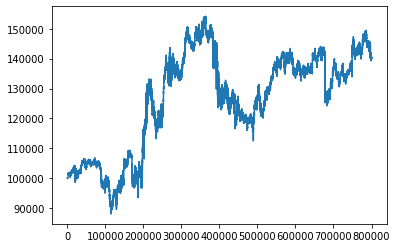

In [16]:
MarketData.initialize(0.0, 1.0, 0, 5)
train_period = 500000
opt_period = 50000
test_period = 800000
pre_test_end =  train_period + opt_period + 1
ldg = LGBMDataGenerator()
lgbm_df = ldg.generate_lgbm_data()
lgbm = LGBM()
train_x, train_y, valid_x, valid_y, opt_x, opt_y, test_x, test_y, start_end_index = ldg.convert_lgbm_data_specified_period(lgbm_df, train_period, opt_period, pre_test_end + 1, test_period)
param = {
            'objective' : 'regression',
            'metric': 'rmse',
            'boosting': 'gbdt',
            #'boosting': 'dart',
            'tree_learner': 'data',
            'learning_rate':0.05,
            'num_iterations':50000,
            'lambda_l1':1.0,
            'lambda_l2':1.0,
            'path_smooth':1.0,
            #'min_gain_to_split':1.0,
            'extra_trees': True,
            #'device_type':'gpu',
            #'num_leaves':18,
            #'gpu_use_dp':True,
            'verbosity':-1,
            #'verbose_eval':False,
            }
low_model = lgbm.train(train_x, pd.to_numeric(train_y['low_vola']), valid_x, pd.to_numeric(valid_y['low_vola']), param)
low_pred, low_ave_rmse = lgbm.prediction(low_model, test_x, pd.to_numeric(test_y['low_vola']))
high_model = lgbm.train(train_x, pd.to_numeric(train_y['high_vola']), valid_x, pd.to_numeric(valid_y['high_vola']), param)
high_pred, high_ave_rmse = lgbm.prediction(high_model, test_x, pd.to_numeric(test_y['high_vola']))
print('low rmse=', low_ave_rmse, ', high rmse=', high_ave_rmse)
lgbm.save_model(low_model, 'low_model.dat')
lgbm.save_model(high_model, 'high_model.dat')
#plt.plot(high_pred)
#plt.plot(low_pred)
high_opt_pred, high_ave_rmse = lgbm.prediction(high_model, opt_x, pd.to_numeric(opt_y['high_vola']))
low_opt_pred, high_ave_rmse = lgbm.prediction(low_model, opt_x, pd.to_numeric(opt_y['low_vola']))
#low_high_width_kijun = 0.006
pt = 0.1
lc = 0.1
opt_ow_high_width_kijun = optLowHighKijun(start_end_index['opt_start'], opt_x, low_opt_pred, high_opt_pred, pt, lc)
#pt, lc = optPTLCLowHighKijun(start_end_index['opt_start'], opt_x, low_opt_pred, high_opt_pred, low_high_width_kijun)
sim = Sim()
ac = sim.lgbm_vola_simple(start_end_index['test_start'], low_pred, high_pred, opt_ow_high_width_kijun, pt, lc)
print('num trade=', ac.num_trade, 'win rate=', ac.win_rate, 'total pl=', ac.total_pl, 'total pl ratio=', ac.total_pl_ratio)
plt.plot(ac.total_asset_log)

initialized MarketData


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Removed  598  data from lgbm_df to exclude nan.
low rmse= 7.480106567684134e-06 , high rmse= 6.247739364908051e-06
num trade= 575 win rate= 0.8243478260869566 total pl= 2821.9216970130838 total pl ratio= 0.02821921697013084


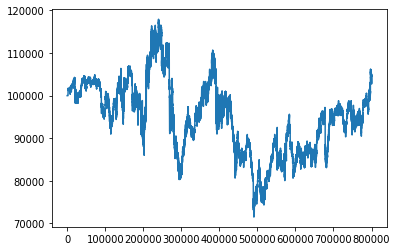

In [17]:
MarketData.initialize(0.0, 1.0, 0, 5)
train_period = 500000
opt_period = 50000
test_period = 800000
pre_test_end =  train_period + opt_period + 1
ldg = LGBMDataGenerator()
lgbm_df = ldg.generate_lgbm_data()
lgbm = LGBM()
train_x, train_y, valid_x, valid_y, opt_x, opt_y, test_x, test_y, start_end_index = ldg.convert_lgbm_data_specified_period(lgbm_df, train_period, opt_period, pre_test_end + 1, test_period)

low_model = lgbm.load_model('low_model.dat')
low_pred, low_ave_rmse = lgbm.prediction(low_model, test_x, pd.to_numeric(test_y['low_vola']))
high_model = lgbm.load_model('high_model.dat')
high_pred, high_ave_rmse = lgbm.prediction(high_model, test_x, pd.to_numeric(test_y['high_vola']))
print('low rmse=', low_ave_rmse, ', high rmse=', high_ave_rmse)
high_opt_pred, high_ave_rmse = lgbm.prediction(high_model, opt_x, pd.to_numeric(opt_y['high_vola']))
low_opt_pred, high_ave_rmse = lgbm.prediction(low_model, opt_x, pd.to_numeric(opt_y['low_vola']))
#low_high_width_kijun = 0.01
pt = 0.1
lc = 0.1
opt_ow_high_width_kijun = optLowHighKijun(start_end_index['opt_start'], opt_x, low_opt_pred, high_opt_pred, pt, lc)
pt, lc = optPTLCLowHighKijun(start_end_index['opt_start'], opt_x, low_opt_pred, high_opt_pred, opt_ow_high_width_kijun)
sim = Sim()
ac = sim.lgbm_vola_simple(start_end_index['test_start'], low_pred, high_pred, opt_ow_high_width_kijun, pt, lc)
print('num trade=', ac.num_trade, 'win rate=', ac.win_rate, 'total pl=', ac.total_pl, 'total pl ratio=', ac.total_pl_ratio)
plt.plot(ac.total_asset_log)

num trade= 81 win rate= 0.8148148148148148 total pl= 20510.94573615519 total pl ratio= 0.2051094573615519


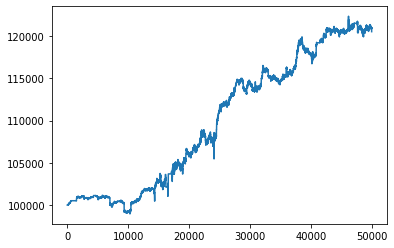

In [ ]:
#low_high_width_kijun = 0.01
#pt = 0.1
#lc = 0.2
exit_time = 100
sim = Sim()
#ac = sim.lgbm_vola_time_exit(start_end_index['test_start'], low_pred, high_pred, low_high_width_kijun, pt, lc, exit_time)
#ac = sim.lgbm_vola_simple(start_end_index['test_start'], low_pred, high_pred, low_high_width_kijun, pt, lc)
ac = sim.lgbm_vola_simple(start_end_index['opt_start'], low_opt_pred, high_opt_pred, opt_ow_high_width_kijun, pt, lc)
print('num trade=', ac.num_trade, 'win rate=', ac.win_rate, 'total pl=', ac.total_pl, 'total pl ratio=', ac.total_pl_ratio)
plt.plot(ac.total_asset_log)

In [18]:
opt_ow_high_width_kijun

0.0053

In [19]:
pt

0.025

In [20]:
lc

0.09

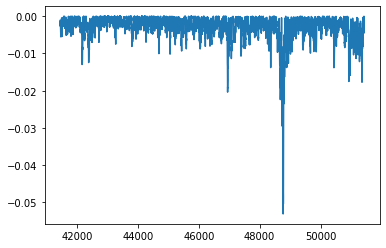

In [ ]:
plt.plot(opt_y['low_vola'])

In [ ]:
lgbm_df['low_vola']

718      -0.014727
719      -0.014353
720      -0.014407
721      -0.013836
722      -0.012836
            ...   
286747         NaN
286748         NaN
286749         NaN
286750         NaN
286751         NaN
Name: low_vola, Length: 286034, dtype: float64

In [ ]:
opt_y['high_vola']

41438    0.000571
41439    0.000424
41440    0.000653
41441    0.000343
41442    0.000767
           ...   
51433    0.003319
51434    0.003331
51435    0.003076
51436    0.003200
51437    0.004988
Name: high_vola, Length: 10000, dtype: float64